# INM705 Coursework
# Fast Neural Style Transfer

In [ ]:
import torch
import torchvision
from torch.autograd import Variable
from collections import namedtuple
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import os
import sys
import random
from PIL import Image
import glob
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import cv2


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Working on {device}')

Working on cuda


In [3]:
#VGG16 will be our pre trained fearure extractor:
        
#ref: https://www.kaggle.com/code/yashchoudhary/fast-neural-style-transfer
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = torchvision.models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        
        
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [4]:
"""
Now we need to build TransformerNet. 
TransformerNet ===> {3xconvBlock -> 5xresidualBlock -> 3convBlock }
We need to define convBlock and residualBlock classes first.
"""

class ConvBlock(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size, stride, normalize=True, upsample = False, relu=True):
        super(ConvBlock, self).__init__()
        self.normalize = normalize
        self.upsample = upsample
        self.relu = relu
        
        #Pads the input tensor using the reflection of the input boundary.
        self.pad1 = nn.ReflectionPad2d(kernel_size//2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.norm = nn.InstanceNorm2d(out_channels, affine=True)
    
    def forward(self,x):
        if self.upsample:
            #upsampling by 2 times using mode algorithm
            x = F.interpolate(x, scale_factor=2)
            
        x = self.pad1(x)
        x = self.conv1(x)
        if self.normalize:
            x = self.norm(x)
            
        if self.relu: x = F.relu(x)
        return x
    
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.convBlock1 = ConvBlock(channels, channels, kernel_size=3, stride=1, relu=True)
        self.convBlock2 = ConvBlock(channels, channels, kernel_size=3, stride=1, relu=False)
    
    def forward(self,x):
        x_c = self.convBlock1(x)
        x_c = self.convBlock2(x_c)
        
        return x_c + x
    

class Transformers(nn.Module):
    def __init__(self,):
        super(Transformers, self).__init__()
        
        self.convBlock1 = ConvBlock(3, 64, kernel_size=9, stride=1)
        self.convBlock2 = ConvBlock(64, 128, kernel_size=3, stride=2)
        self.convBlock3 = ConvBlock(128, 256, kernel_size=3, stride=2)
        #self.convBlock4 = ConvBlock(256, 512, kernel_size=3, stride=2)
        
        self.resBlock = ResidualBlock(256)

        #self.convBlock4 = ConvBlock(256, 128, kernel_size=3,stride=1, upsample=True)
        self.convBlock4 = ConvBlock(256, 128, kernel_size=3,stride=1, upsample=True)
        self.convBlock5 = ConvBlock(128, 64, kernel_size=9, stride=1,upsample=True)
        self.convBlock6 = ConvBlock(64, 3, kernel_size=9, stride=1, normalize= False, relu=False)
        
        
    def forward(self,x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = self.convBlock3(x)
        
        for _ in range(5): x = self.resBlock(x)

        
        x = self.convBlock4(x)
        x = self.convBlock5(x)
        x = self.convBlock6(x)
        
        return x
    
        
      

In [5]:


def get_content_cost_one_layer(content_img_feature, generated_img_feature):
    """
    This function only considers one layer only.
    """
    batch,channels, height, width  = content_img_feature.size()

    #print(f'{height} {width} {channels}')
    
    #we need to iterate on the spatial region of images (height x width) across three channels:
    content_spatial = content_img_feature.view((batch,channels, height*width))
    generated_spatial = generated_img_feature.view((batch,channels, height*width))
    
    element_wise_diff = torch.subtract(content_spatial, generated_spatial)
    squared_diff = torch.square(element_wise_diff)
    
    factor = 1/(4*channels*width*height)
    content_cost = factor*torch.sum(squared_diff)
    return content_cost
#get_content_cost(content_img, generated_img)

def get_content_cost(content_img_op, generated_img_op, use_all_layers = False):
    cost = 0
    if use_all_layers:
        #iterating on all the features cooresponding to our choosen layers:
        for content_img_feature, generated_img_feature in zip(content_img_op[:-1], generated_img_op[:-1]):
            cost += get_content_cost_one_layer(content_img_feature, generated_img_feature)
    else:
        cost += get_content_cost_one_layer(content_img_op[-1], generated_img_op[-1])
        
    return cost


def get_style_cost_one_layer(style_img_l, generate_img_l):
    
    #getting dimensions from the activation layer input:
    batch_st,channels, height, width = style_img_l.size()
    
    #resizing the tensors to infold along height and width:
    style_img_l = style_img_l.view((batch,channels, height*width))
    generate_img_l = generate_img_l.view((batch,channels, height*width))

    # print('checking.....', style_img_l)
    #calculating the gram matrices:
    gram_style = style_img_l.bmm(style_img_l.transpose(1,2))
    #torch.linalg.matmul(style_img_l, torch.transpose(style_img_l,0,1))
    gram_generate = generate_img_l.bmm(generate_img_l.transpose(1,2))
    #torch.linalg.matmul(generate_img_l, torch.transpose(generate_img_l,0,1))
    
    #calculating the cost:
    gram_difference = torch.subtract(gram_style,gram_generate)
    gram_diff_squared = torch.square(gram_difference)
    
    #defining the factor:
    factor = 1/(2*channels*height*width)
    
    return factor*factor*torch.sum(gram_diff_squared)
    
    
def get_style_cost(style_img_op, generated_img_op, cur_batch_size, loss_func):
    #if not use_all_layers:
    # style_img_op = style_img_op[:-1]
    # generated_img_op = generated_img_op[:-1]
        
    cost = 0
    
    for ft_y, ft_s in zip(generated_img_op, style_img_op):
        gram_generate = gram_matrix(ft_y)
        gram_style = gram_matrix(ft_s)
        gram_style = gram_style[: cur_batch_size, :, :]
        
        #cost += loss_func(gram_generate, gram_style)
        #calculating the cost:
        gram_difference = torch.subtract(gram_style,gram_generate)
        gram_diff_squared = torch.square(gram_difference)
        cost += torch.sum(gram_diff_squared)
    
        
        
    return cost


def get_total_cost(alpha, beta, content_cost, style_cost):
    # content_cost = get_content_cost(content_img, generated_img)
    # style_cost = get_style_cos(style_img, generated_img)
    return alpha*content_cost + beta*style_cost




In [6]:
#ref: https://www.kaggle.com/code/yashchoudhary/fast-neural-style-transfer

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def transform(image_set, image_size = None):
    if image_set == 'train':
        transform = transforms.Compose(
        [
            transforms.Resize((int(image_size),int(image_size))),
            #transforms.RandomCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
        )
        return transform
        
    elif image_set == 'style':
        #Transforms for style image
        resize = [transforms.Resize((image_size,image_size))] if image_size else []
        #transform = transforms.Compose(resize + [transforms.ToTensor()])
        transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
        
        return transform
        
    elif image_set == 'test':
        #Transforms for test image
        resize = [transforms.Resize(image_size)] if image_size else []
        #transform = transforms.Compose(resize + [transforms.ToTensor()])
        transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
        
        return transform
        


def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors


def deprocess(image_tensor):
    """ Denormalizes and rescales image tensor """
    image_tensor = denormalize(image_tensor)[0]
    image_tensor *= 255
    image_np = torch.clamp(image_tensor, 0, 255).cpu().numpy().astype(np.uint8)
    image_np = image_np.transpose(1, 2, 0)
    return image_np


def gram_matrix(y):
    """ Returns the gram matrix of y (used to compute style loss) """
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram

In [7]:
def getStyleFeatures(style_img_dir, style_img_size,vgg, train_batch_size):
    
    style_img = Image.open(style_img_dir)
    style_img = transform('style', style_img_size)(style_img)
    #we must use the same style image for our batch
    style_img = style_img.repeat(train_batch_size, 1, 1, 1).to(device)
    
    features = vgg(style_img)
    # gram_matrix(y) for y in features_style
    # gram_features = []
    # for y in features:
    #     batch, channel, height, width = y.size()
    #     y_l = y.view((batch,channels, height*width))
    #     gram_y = y_l.bmm(y_l.transpose(1,2))
    #     gram_features.append(gram_y/(channel*height*width))
    
    return features
    #return [gram_matrix(y) for y in features]
    


    
def train(models, style_name, style_features, val_img_samples, lr, dataloader, epochs, alpha, beta, batch_size,load_model = None):
    os.makedirs(f"./images/outputs/{style_name}-training", exist_ok=True)
    os.makedirs(f"./checkpoints", exist_ok=True)
    
    transformer, vgg = models
    start_epoch, end_epoch = 0, epochs
    
    if load_model:
        transformer.load_state_dict(torch.load(load_model))
        last_epoch = int(load_model.split('/')[-1].split('_')[-1].split('.')[0])
        start_epoch += last_epoch
        end_epoch += last_epoch
        
    optimizer = Adam(transformer.parameters(), lr)
    loss_func = torch.nn.MSELoss().to(device)
    
    train_hist = {"content": [], "style": [], "total": []}
    
    for e in range(start_epoch+1,end_epoch+1):
        epoch_hist = {"content": [], "style": [], "total": []}
        
        for batch_idx, (tr_images, _) in enumerate(dataloader):
            #print(tr_images.size())
            #if : continue
            optimizer.zero_grad()
            tr_images = tr_images.to(device)
            
            #passing the batch through our transformer:
            transformer_output = transformer(tr_images)
            #print(tr_images)
            #eaxtracting features:
            tr_image_feat = vgg(tr_images)
            transformer_output_feat = vgg(transformer_output)

        
            #content_cost = get_content_cost(tr_image_feat, transformer_output_feat, use_all_layers = False)
            
            #print(style_features, len(transformer_output_feat))
            content_cost = alpha*loss_func(transformer_output_feat.relu2_2, tr_image_feat.relu2_2)
            style_cost = beta*get_style_cost(style_features, transformer_output_feat, tr_images.size(0), loss_func)
            #print(style_cost.item())
            #total_cost = get_total_cost(alpha, beta, content_cost, style_cost)
            total_cost = content_cost + style_cost
            
            total_cost.backward()
            optimizer.step()
            
            epoch_hist["content"] += [content_cost.item()]
            epoch_hist["style"] += [style_cost.item()]
            epoch_hist["total"] += [total_cost.item()]
            
            train_hist["content"] += [content_cost.item()]
            train_hist["style"] += [style_cost.item()]
            train_hist["total"] += [total_cost.item()]
            
            
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Content: %.2f (%.2f) Style: %.2f (%.2f) Total: %.2f (%.2f)]"
                % (
                    e,
                    epochs,
                    batch_idx,
                    len(train_data)//batch_size,
                    content_cost.item(),
                    np.mean(epoch_hist["content"]),
                    style_cost.item(),
                    np.mean(epoch_hist["style"]),
                    total_cost.item(),
                    np.mean(epoch_hist["total"]),
                )
            )

            if (batch_idx+1)%500 == 0:
                transformer.eval()
                with torch.no_grad():
                    output = transformer(val_img_samples.to(device))
                image_grid = denormalize(torch.cat((val_img_samples.cpu(), output.cpu()), 2))
                save_image(image_grid, f"./images/outputs/{style_name}-training/{batch_idx}.jpg", nrow=4)
                transformer.train()

            if (batch_idx+1)%1000 == 0:
                torch.save(transformer.state_dict(), f"saved_models/{style_name}_{batch_idx}.pth")

                
    print("Training Completed!")
    return train_hist

    
                
                

def evaluate(test_img_dir, saved_model, destination_path):
    os.makedirs(os.path.join(destination_path,"results"), exist_ok=True)
    img = Image.open(test_img_dir)
    img = transform('test')(img)
    img = Variable(img).to(device)
    img = img.unsqueeze(0)
    
    model = Transformers().to(device)
    model.load_state_dict(torch.load(saved_model))
    model.eval()

    with torch.no_grad():
        output = model(img)
        stylized_image = denormalize(output).cpu()
        #stylized_image = output
    # Saving image
    cnt_im = test_img_dir.split('/')[-1].split('.')[0]
    fn = saved_model.split('/')[-1].split('.')[0]
    save_image(stylized_image, os.path.join(destination_path,f"results/{fn}_{cnt_im}-output.jpg"))
    print("Image Saved!")
    plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(destination_path,f"results/{fn}_{cnt_im}-output.jpg")), cv2.COLOR_BGR2RGB))
    

In [8]:
#define NST parameters:
alpha = 25
beta = 15

#defining training parameters:
epochs = 1
lr = 0.00001
dataset_dir = 'train_data/'
train_image_size = 500
train_batch_size = 8
train_data = datasets.ImageFolder(dataset_dir, transform('train', train_image_size))
train_dataloader = DataLoader(train_data, batch_size=train_batch_size)

transformer = Transformers().to(device)
vgg = VGG16().to(device)
models = [transformer, vgg]
#defining style parameters:
style_img_size = 500
style_img_dir = 'Styles/cyberpunk.jpg'
#style_gram_features = getStyleFeatures(style_img_dir, style_img_size,vgg, train_batch_size)
style_features = getStyleFeatures(style_img_dir, style_img_size,vgg, train_batch_size)


#validation parameters:
val_img_samples = []
for path in random.sample(glob.glob(f"{dataset_dir}/*/*.jpg"), 8):
    img = Image.open(path)
    val_img_samples += [transform('style',style_img_size)(img)]
    
val_img_samples = torch.stack(val_img_samples)


#load_model = 'saved_models/abstract1_10.pth'
load_model = None

In [16]:
style_name = 'cyberpunk'
train_hist = train(models, style_name, style_features, val_img_samples, lr, train_dataloader, epochs, alpha, beta, train_batch_size,load_model)

[Epoch 1/1] [Batch 5083/5083] [Content: 359.04 (373.63) Style: 89.91 (248.62) Total: 448.95 (622.24)]Training Completed!


## Without RandomCrop

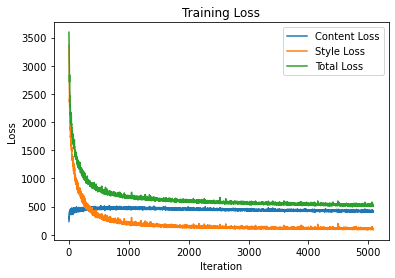

In [17]:
#printing the loss curve.
#x = range(1,5000,100)
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
cnt_loss = train_hist["content"]
style_loss = train_hist["style"]
tot_loss = train_hist["total"]
plt.plot(cnt_loss, label = "Content Loss")
plt.plot(style_loss, label = "Style Loss")
plt.plot(tot_loss, label = "Total Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


Image Saved!


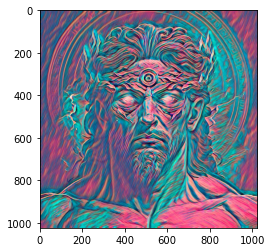

In [18]:
test_img_dir = 'Contents/2.jpg'
saved_model = 'saved_models/abstract1_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


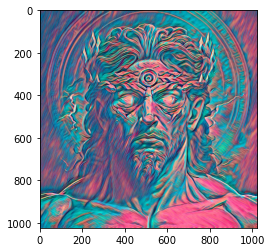

In [17]:
test_img_dir = 'Contents/2.jpg'
saved_model = 'saved_models/acrylic6_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

## Without Normalization

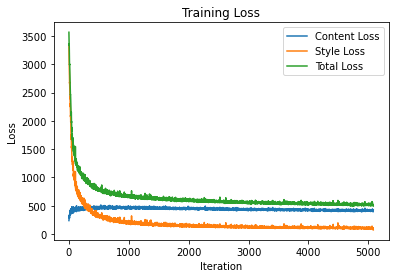

In [23]:
#printing the loss curve.
#x = range(1,5000,100)
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
cnt_loss = train_hist["content"]
style_loss = train_hist["style"]
tot_loss = train_hist["total"]
plt.plot(cnt_loss, label = "Content Loss")
plt.plot(style_loss, label = "Style Loss")
plt.plot(tot_loss, label = "Total Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


Image Saved!
Image Saved!
Image Saved!
Image Saved!


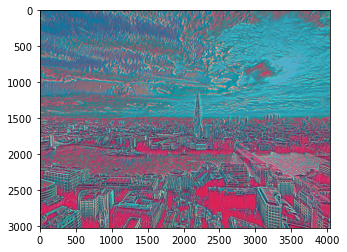

In [12]:
test_img_dir_ls = ['Contents/1.jpg', 'Contents/2.jpg', 'Contents/3.jpg', 'Contents/4.jpg' ]
saved_model = 'saved_models/abstract1_4999.pth'
destination_path = 'generated_test_images/'
for test_img_dir in test_img_dir_ls:
    evaluate(test_img_dir, saved_model, destination_path)

## with alpha beta 25:15

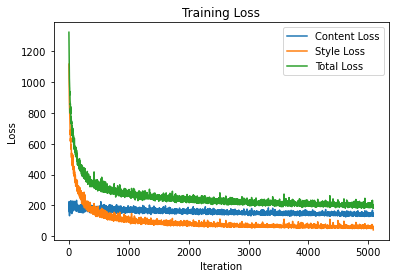

In [15]:
#printing the loss curve.
#x = range(1,5000,100)
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
cnt_loss = train_hist["content"]
style_loss = train_hist["style"]
tot_loss = train_hist["total"]
plt.plot(cnt_loss, label = "Content Loss")
plt.plot(style_loss, label = "Style Loss")
plt.plot(tot_loss, label = "Total Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


Image Saved!


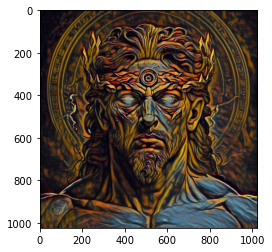

In [16]:
test_img_dir = 'Contents/2.jpg'
saved_model = 'saved_models/acrylic6_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

## With alpha beta 20:20

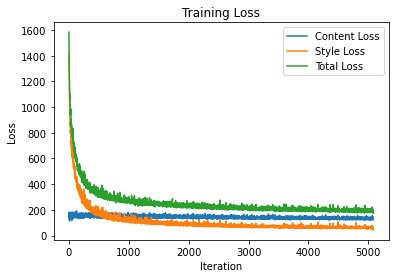

In [10]:
#printing the loss curve.
#x = range(1,5000,100)
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
cnt_loss = train_hist["content"]
style_loss = train_hist["style"]
tot_loss = train_hist["total"]
plt.plot(cnt_loss, label = "Content Loss")
plt.plot(style_loss, label = "Style Loss")
plt.plot(tot_loss, label = "Total Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


Image Saved!


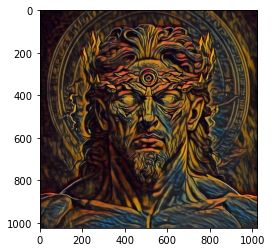

In [11]:
test_img_dir = 'Contents/2.jpg'
saved_model = 'saved_models/acrylic6_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

## With alpha 10 beta 30

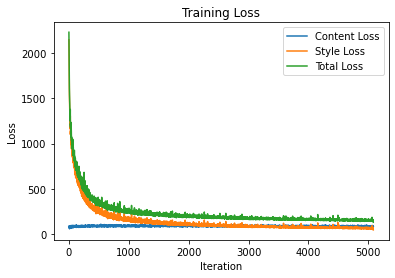

In [10]:
#printing the loss curve.
#x = range(1,5000,100)
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
cnt_loss = train_hist["content"]
style_loss = train_hist["style"]
tot_loss = train_hist["total"]
plt.plot(cnt_loss, label = "Content Loss")
plt.plot(style_loss, label = "Style Loss")
plt.plot(tot_loss, label = "Total Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


Image Saved!


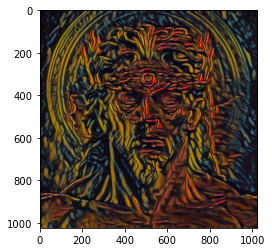

In [11]:
test_img_dir = 'Contents/2.jpg'
saved_model = 'saved_models/acrylic6_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

## With alpha 0 beta 30

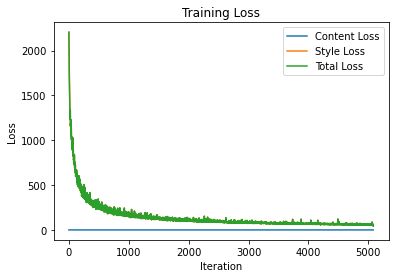

In [14]:
#printing the loss curve.
#x = range(1,5000,100)
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
cnt_loss = train_hist["content"]
style_loss = train_hist["style"]
tot_loss = train_hist["total"]
plt.plot(cnt_loss, label = "Content Loss")
plt.plot(style_loss, label = "Style Loss")
plt.plot(tot_loss, label = "Total Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


Image Saved!


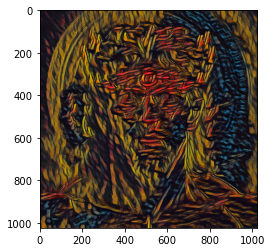

In [15]:
test_img_dir = 'Contents/2.jpg'
saved_model = 'saved_models/acrylic6_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

## Neon Red

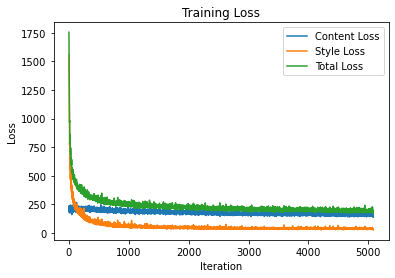

In [14]:
#printing the loss curve.
#x = range(1,5000,100)
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
cnt_loss = train_hist["content"]
style_loss = train_hist["style"]
tot_loss = train_hist["total"]
plt.plot(cnt_loss, label = "Content Loss")
plt.plot(style_loss, label = "Style Loss")
plt.plot(tot_loss, label = "Total Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


Image Saved!


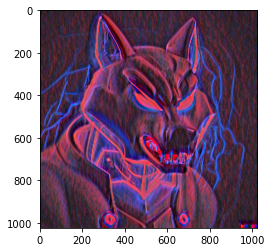

In [15]:
test_img_dir = 'Contents/wolf1.jpg'
saved_model = 'saved_models/redneon_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


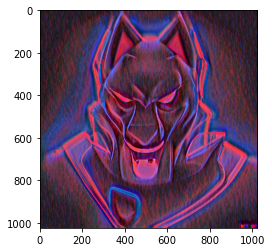

In [16]:
test_img_dir = 'Contents/wolf2.jpg'
saved_model = 'saved_models/redneon_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

## Light

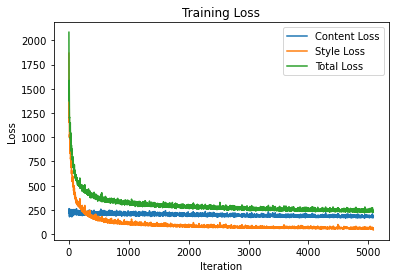

In [10]:
#printing the loss curve.
#x = range(1,5000,100)
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
cnt_loss = train_hist["content"]
style_loss = train_hist["style"]
tot_loss = train_hist["total"]
plt.plot(cnt_loss, label = "Content Loss")
plt.plot(style_loss, label = "Style Loss")
plt.plot(tot_loss, label = "Total Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


Image Saved!


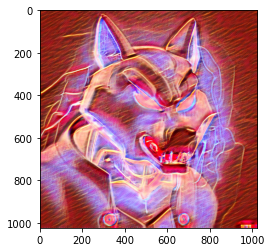

In [13]:
test_img_dir = 'Contents/wolf1.jpg'
saved_model = 'saved_models/lights_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

## Cyberpunk

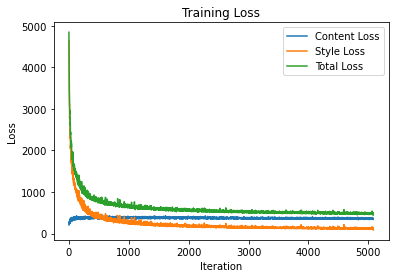

In [17]:
#printing the loss curve.
#x = range(1,5000,100)
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
cnt_loss = train_hist["content"]
style_loss = train_hist["style"]
tot_loss = train_hist["total"]
plt.plot(cnt_loss, label = "Content Loss")
plt.plot(style_loss, label = "Style Loss")
plt.plot(tot_loss, label = "Total Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


Image Saved!


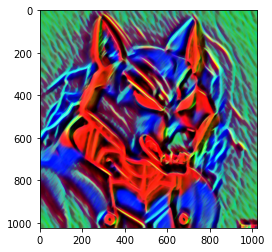

In [18]:
test_img_dir = 'Contents/wolf1.jpg'
saved_model = 'saved_models/cyberpunk_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


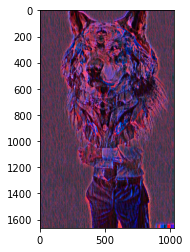

In [21]:
test_img_dir = 'Contents/wolf-tech.jpg'
saved_model = 'saved_models/redneon_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

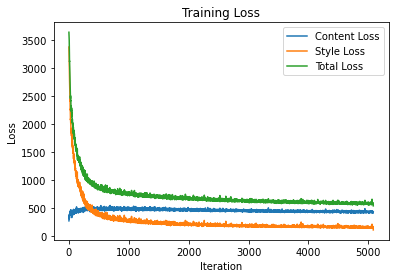

In [24]:
#printing the loss curve.
#x = range(1,5000,100)
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
cnt_loss = train_hist["content"]
style_loss = train_hist["style"]
tot_loss = train_hist["total"]
plt.plot(cnt_loss, label = "Content Loss")
plt.plot(style_loss, label = "Style Loss")
plt.plot(tot_loss, label = "Total Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


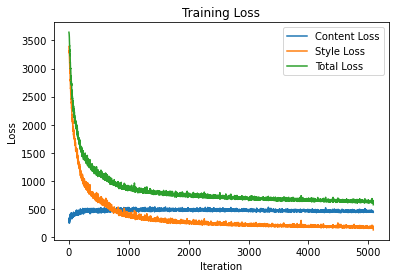

In [48]:
#printing the loss curve.
#x = range(1,5000,100)
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
# train_hist = [el*10**4 for el in train_hist]
cnt_loss = train_hist["content"]
style_loss = train_hist["style"]
tot_loss = train_hist["total"]
plt.plot(cnt_loss, label = "Content Loss")
plt.plot(style_loss, label = "Style Loss")
plt.plot(tot_loss, label = "Total Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


In [41]:
gs = fig.add_gridspec(3, hspace=3)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('Sharing both axes')
axs[0].plot(cnt_loss, 'tab:orange')
axs[1].plot(style_loss,'tab:red')
axs[2].plot(tot_loss, 'tab:green')
# axs[0].set_title('Content Loss')
# axs[1].set_title('Style Loss')
# axs[2].set_title('Total Loss')


In [ ]:
torch.save(transformer.state_dict(), "saved_models/trans10.pth")

Image Saved!


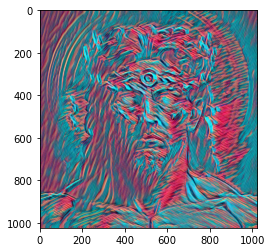

In [17]:
test_img_dir = 'Contents/2.jpg'
saved_model = 'saved_models/abstract1_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


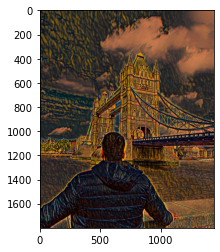

In [14]:
test_img_dir = 'Contents/1.jpg'
saved_model = 'saved_models/acrylic6_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


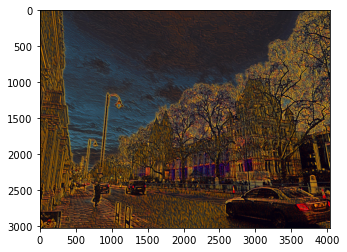

In [17]:
test_img_dir = 'Contents/3.jpg'
saved_model = 'saved_models/acrylic6_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


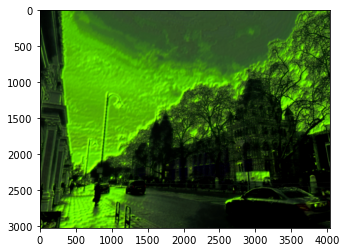

In [13]:
test_img_dir = 'Contents/3.jpg'
saved_model = 'saved_models/aurora2_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


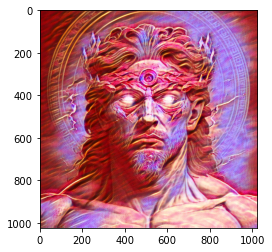

In [14]:
test_img_dir = 'Contents/2.jpg'
saved_model = 'saved_models/lights_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


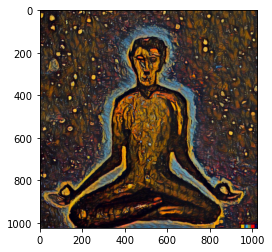

In [16]:
test_img_dir = 'Contents/thesaint.png'
saved_model = 'saved_models/acrylic6_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


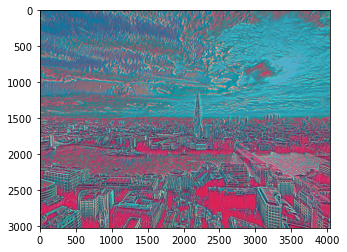

In [11]:
test_img_dir = 'Contents/4.jpg'
saved_model = 'saved_models/abstract1_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


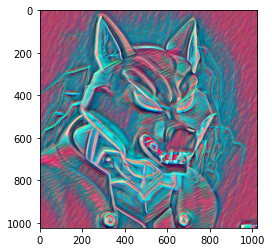

In [17]:

test_img_dir = 'Contents/wolf1.jpg'
saved_model = 'saved_models/abstract1_4999.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


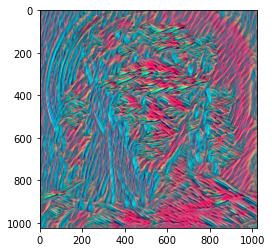

In [11]:

test_img_dir = 'Contents/2.jpg'
saved_model = 'saved_models/abstract1_6.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


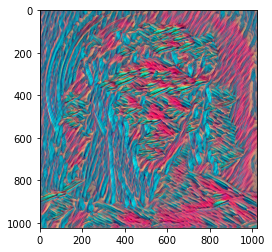

In [12]:

test_img_dir = 'Contents/2.jpg'
saved_model = 'saved_models/abstract1_8.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


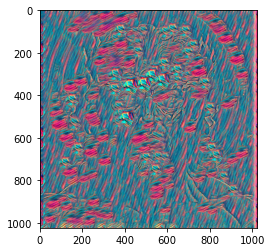

In [26]:

test_img_dir = 'Contents/2.jpg'
saved_model = 'saved_models/abstract1_12.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


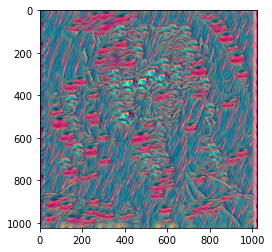

In [27]:

test_img_dir = 'Contents/2.jpg'
saved_model = 'saved_models/abstract1_16.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)

Image Saved!


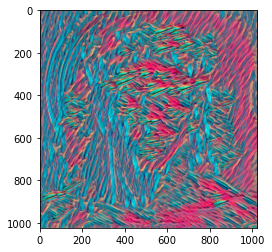

In [10]:

test_img_dir = 'Contents/2.jpg'
saved_model = 'saved_models/abstract1_10.pth'
destination_path = 'generated_test_images/'
evaluate(test_img_dir, saved_model, destination_path)